# Apply pre-trained priors for MRI image reconstruction
**Authors**: [Guanxiong Luo](mailto:guanxiong.luo@med.uni-goettingen.de), [Nick Scholand](mailto:nick.scholand@med.uni-goettingen.de), [Christian Holme](mailto:christian.holme@med.uni-goettingen.de)

**Will take around 30 mins to go through this tutorial.**

**Have fun with it! If you have any questions, don't hesitate to drop us a line.**

## 1. Set up the environment

### 1. Download and Compile `bart`
If you are running this notebook in the environment that has bart already installed, there is no need run this part.

In [ ]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Download BART version
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart
[ -d "bart" ] && echo "BART was downloaded successfully."

cd bart
make &> /dev/null

After compilation of BART we need to set the required environmental variable: `TOOLBOX_PATH`

In [ ]:
%env TOOLBOX_PATH=/content/bart

Additionally, we add the compiled `bart` executable to our `PATH` variable

In [ ]:
import os
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']

Check if bart toolbox is working properly

In [ ]:
%%bash
bart version

### 2. Install `spreco`
Download the package spreco and install it with the `pip` command.

In [ ]:
%%bash
pip uninstall tensorflow-gpu
pip install tensorflow-gpu==2.4.1
git clone https://github.com/mrirecon/spreco.git
cd spreco
pip install .

In [ ]:
%%bash
curl https://zenodo.org/record/6521188/files/pre-trained.tar?download=1 --output pre-trained.tar
curl https://zenodo.org/record/6521188/files/full_kspace.npz?download=1 --output full_kspace.npz
mkdir spreco/data
tar xf pre-trained.tar -C spreco/data
mv full_kspace.npz spreco/data

## 2. Execute reconstruction

### 1. Import modules 

`ops` contains simple functionalities for building the forward operator for the k-space measurement $\mathbf{y}=\mathcal{A}\mathbf{x}+\epsilon$.

`sde` contains the class for training reverse transitions $p_\theta(\mathbf{x}_i|\mathbf{x}_{i+1})$.

`posterior_sampler` contains the class for simulating samples from $p({\mathbf{x}|\mathbf{y}})$ given the learned transitions and the measured k-space.

`utils` contains utilities for the calling to bart, loading configuration, converting complex arrays to float arrays and so on.

In [1]:
from spreco.common import ops, sampling_pattern, utils
from spreco.model.sde import sde, posterior_sampler

import os
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from functools import partial

### 2. Load the configuration for reconstruction

The configuration file for reconstruction specifies the following options.

1. which model is used to construct transition kernel?
2. which sampling pattern is used?
3. how many samples will be drawn from the posterior?
4. where to store the results?
5. the values of K, N, $\lambda$ in the proposed algorithm?
6. whether to use burn-in phase, at which time point to be burned?
7. where is the k-space data?

Example for the recon config file.

```yaml
cal: 20         # calibration region
fx: 1.5         # if possion sampling is used, acceleration along x direction
fy: 1.5         # if possion sampling is used, acceleration along y direction
poisson: true   # possion sampling pattern
sampling_rate: 0.2  # if possion samples is not used, use Gaussian sampling pattern instead
s_stepsize: 25  # $\lambda$ in Algorithm 1
st: 30          # N=100-st in Algorithm 1
c_steps: 5      # K in Algorithm 1
nr_samples: 10  # how many samples will be drawn
burn_in: false
burn_t: 0.5     # at which time point to be burn
disable_z: True
target_snr: 1

model_folder: xxxx
model_name: xxx
ksp_path: xxx    # kspace location
gpu_id: '3'
```

check your `recon_config` file, especially the params for the location of kspace and model, and load the configuration with `utils`, 

In [10]:
config_path  ='/content/spreco/scripts/recon_config.yaml'
config       = utils.load_config(config_path)
model_config = utils.load_config(config['model_folder']+'/config.yaml')

model_path   = os.path.join(config['model_folder'], config['model_name'])
np.random.seed(model_config['seed'])
np.random.seed(model_config['seed'])

### 3. Prepare the undersampled k-space data

1. load the fully sampled k-space
2. generate the undersampling mask with `bart` or `sampling_pattern`
3. compute coil sensitivities with `ecalib`
4. build the operator for the k-space measurement.
5. compute the ground truth from fully sampled k-space and zero-filled from undersampled k-space

In [11]:
def prepare_simu(config, mask=None):
        
    kspace = np.squeeze(np.load(config['ksp_path'])['kspace'])

    nx, ny, _ = kspace.shape
    coilsen = np.squeeze(utils.bart(1, 'ecalib -m1 -r20 -c0.001', kspace[np.newaxis, ...]))
    img_shape = [nx, ny]
    std_coils = ops.mifft2(kspace, img_shape)

    rss = np.sum(np.multiply(std_coils, np.squeeze(np.conj(coilsen))), axis=2)

    if mask is None:
        if not config['poisson']:
            mask = sampling_pattern.gen_mask_2D(nx, ny, center_r = config['cal'], undersampling = config['sampling_rate'])
        else:
            mask = utils.bart(1, 'poisson -Y %d -Z %d -y %f -z %f -s 1234 -v -C %d'%(nx, ny, config['fx'], config['fy'], config['cal']))
            mask = np.squeeze(mask)

    und_ksp = kspace*abs(mask[..., np.newaxis])

    coilsen = np.squeeze(utils.bart(1, 'ecalib -m1 -r20 -c0.001', kspace[np.newaxis, ...]))
    coilsen = np.squeeze(coilsen)
    x_ = ops.AT_cart(und_ksp, coilsen, mask, img_shape)

    return x_, mask, coilsen, (nx, ny), rss, und_ksp

zero_filled, mask, coilsen, shape, rss, und_ksp = prepare_simu(config)
zero_filled = utils.float2cplx(utils.normalize_with_max(zero_filled)) # [-1, 1]
l1_recon    = utils.bart(1, 'pics -l1 -r 0.01', und_ksp[:,:,np.newaxis,:], coilsen[:,:,np.newaxis,:])

grad_params = {'coilsen': coilsen[np.newaxis, ...], 'mask': mask[np.newaxis, ...], 'shape': shape, 'center': False}
AHA         = partial(ops.AHA, **grad_params)

bart ecalib -m1 -r20 -c0.001 /tmp/tmp4fgb6yumin0 /tmp/tmp4fgb6yumout0
Done.
bart poisson -Y 256 -Z 256 -y 1.500000 -z 1.500000 -s 1234 -v -C 20  /tmp/tmpgaxhql0hout0
points: 7736, grid size: 256x256 = 65536 (R = 8.471561)
bart ecalib -m1 -r20 -c0.001 /tmp/tmpg0buzrq2in0 /tmp/tmpg0buzrq2out0
Done.
bart pics -l1 -r 0.01 /tmp/tmpmgf50wt6in0 /tmp/tmpmgf50wt6in1 /tmp/tmpmgf50wt6out0
Size: 65536 Samples: 7733 Acc: 8.47
l1-wavelet regularization: 0.010000
FISTA
Total Time: 0.363947


### 4. Run the sampler for $p(\mathbf{x}|\mathbf{y})$

1. create two placeholders for the image $\mathbf{x}$ and noise indices $i$
2. instantiate the neural network
3. restore the pre-trained model
4. run the sampler with the learned transitions and the measured k-space.
5. save results

In [4]:
## network
x          = tf.placeholder(tf.float32, shape=[None]+model_config['input_shape']) 
t          = tf.placeholder(tf.float32, shape=[None]) 
ins_sde    = sde(model_config)
_          = ins_sde.net.forward(x, t)
all_params = tf.trainable_variables()
saver      = tf.train.Saver()
sess       = tf.Session()

sess.run(tf.global_variables_initializer())
saver.restore(sess, os.path.join(config['model_folder'], config['model_name']))

ins_sampler = posterior_sampler(ins_sde, 
                            steps=config['c_steps'],
                            target_snr=config['target_snr'],
                            nr_samples = config['nr_samples'],
                            burn_in=config['burn_in'],
                            burn_t=config['burn_t'],
                            map_end = False if 'map_end' not in config.keys() else config['map_end'],
                            last_iteration = 5 if 'last_iteration' not in config.keys() else config['last_iteration'], 
                            last_step_factor= 1 if 'last_step_factor' not in config.keys() else config['last_step_factor'],
                            disable_z = False if 'disable_z' not in config.keys() else config['disable_z'])

images = ins_sampler.conditional_ancestral_sampler(x, t, sess, AHA, zero_filled[np.newaxis, ...], config['s_stepsize'], st=config['st'])

if config['burn_in']:
    idx = int(ins_sampler.sde.N*config['burn_t']*config['c_steps']) - config['c_steps']
    images = utils.float2cplx(np.array(images[-idx:]))
else:
    images = np.array(images)
    images = images[...,0]+1.0j*images[...,1]

2022-02-16 09:38:01.622577: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 09:38:03.092552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 72629 MB memory:  -> device: 0, name: A100-SXM-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


INFO:tensorflow:Restoring parameters from /home/ague/archive/projects/2021/gluo/mcmc_recon/models/net2/20211007-232921/sde_brain_500


  0%|                                                                                                                                                 | 0/69 [00:00<?, ?it/s]2022-02-16 09:38:10.943923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-16 09:38:11.853826: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [06:26<00:00,  5.61s/it]


## 3. Results

1. normalize reconstruction 
2. plot the curves to track PSNR and SSIM over iterations
3. compare reconstruction
4. plot image over intermediate distributions



### 1. Normalize reconstruction

In [5]:
# normalize the results
mag_rets = np.abs(images)/np.max(abs(images), axis=(2,3))[..., np.newaxis, np.newaxis]
mag_rss         = abs(rss)
normalized_zero_filled=abs(zero_filled/np.linalg.norm(zero_filled))
normalized_l1_recon=abs(l1_recon/np.linalg.norm(l1_recon))
normalized_rss  = mag_rss/np.linalg.norm(mag_rss)
normalized_rets = mag_rets/np.linalg.norm(mag_rets, axis=(2,3), keepdims=True)

total_steps = mag_rets.shape[0]
step_size = 1

normalized_expectation_1  = normalized_rets[:total_steps:step_size,0,...]
normalized_expectation_2  = np.mean(normalized_rets[:total_steps:step_size,0:2,...], axis=1)
normalized_expectation_4  = np.mean(normalized_rets[:total_steps:step_size,1:4,...], axis=1)
normalized_expectation_8  = np.mean(normalized_rets[:total_steps:step_size,1:8,...], axis=1)
normalized_expectation_10 = np.mean(normalized_rets[:total_steps:step_size], axis=1)

# calculate psnrs and ssims

psnrs=[]
ssims=[]

for i in range(int(total_steps/step_size)):
    tmp_psnr=[]
    tmp_ssim=[]
    tmp_psnr.append(utils.psnr(normalized_expectation_1[i], normalized_rss))
    tmp_ssim.append(utils.ssim(normalized_expectation_1[i], normalized_rss))

    tmp_psnr.append(utils.psnr(normalized_expectation_2[i], normalized_rss))
    tmp_ssim.append(utils.ssim(normalized_expectation_2[i], normalized_rss))

    tmp_psnr.append(utils.psnr(normalized_expectation_4[i], normalized_rss))
    tmp_ssim.append(utils.ssim(normalized_expectation_4[i], normalized_rss))

    tmp_psnr.append(utils.psnr(normalized_expectation_8[i], normalized_rss))
    tmp_ssim.append(utils.ssim(normalized_expectation_8[i], normalized_rss))

    tmp_psnr.append(utils.psnr(normalized_expectation_10[i], normalized_rss))
    tmp_ssim.append(utils.ssim(normalized_expectation_10[i], normalized_rss))
    psnrs.append(tmp_psnr)
    ssims.append(tmp_ssim)

psnrs = np.array(psnrs)
ssims = np.array(ssims)

### 2. Plot the curves to track PSNR and SSIM over iterations

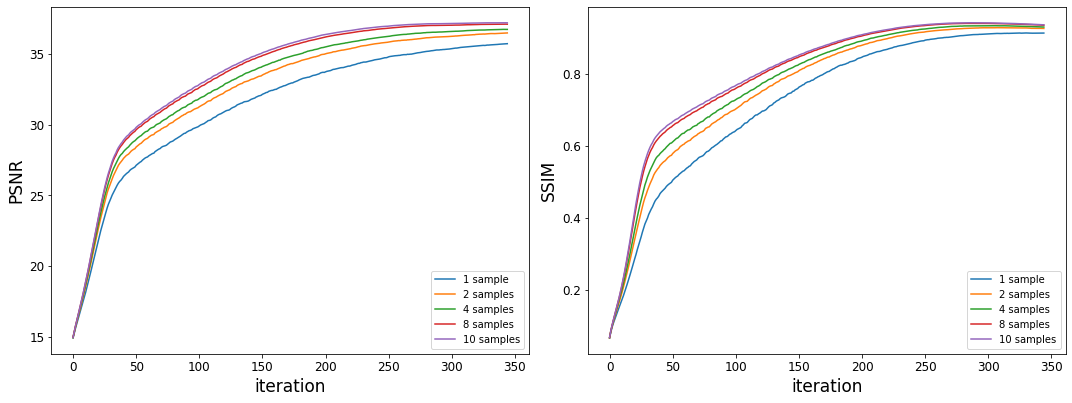

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
import math

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5.7), gridspec_kw={'width_ratios': [1, 1]})
fontsize = 17
ticksize = 12
for i,c in enumerate([1,2,4,8,10]):
    ax1.plot(psnrs[:,i], label= "{} sample".format(c) if c==1 else "{} samples".format(c))
    ax2.plot(ssims[:,i], label= "{} sample".format(c) if c==1 else "{} samples".format(c))

ax1.set_xlabel('iteration', fontsize=fontsize)
ax1.set_ylabel('PSNR', fontsize=fontsize)
ax1.tick_params(labelsize=ticksize) 
ax1.legend(loc='lower right')

ax2.set_xlabel('iteration', fontsize=fontsize)
ax2.set_ylabel('SSIM', fontsize=fontsize)
ax2.tick_params(labelsize=ticksize) 
ax2.legend(loc='lower right')
plt.tight_layout()

### 3. Compare reconstruction methods

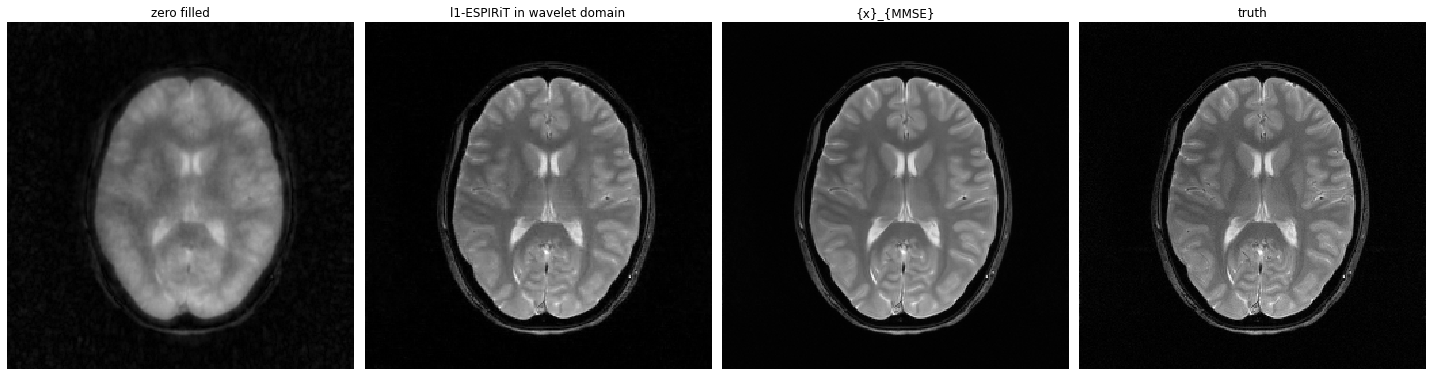

In [7]:

def subplot(ax, img, title, cmap, interpolation, vmin, vmax):
    ax.imshow(img, cmap=cmap, interpolation=interpolation, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

rss_max = np.max(normalized_rss)
plot_params = {'cmap': 'gray', 'interpolation': 'none', 'vmin': 0, 'vmax': rss_max}
axplot      = partial(subplot, **plot_params)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7.6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
axplot(ax1, normalized_zero_filled, title='zero filled')
axplot(ax2, normalized_l1_recon, title='l1-ESPIRiT in wavelet domain')
axplot(ax3, normalized_expectation_10[-1], '{x}_{MMSE}')
axplot(ax4, normalized_rss, 'truth')
plt.tight_layout()

### 4. Create grid of samples and generative the gif for iterations.

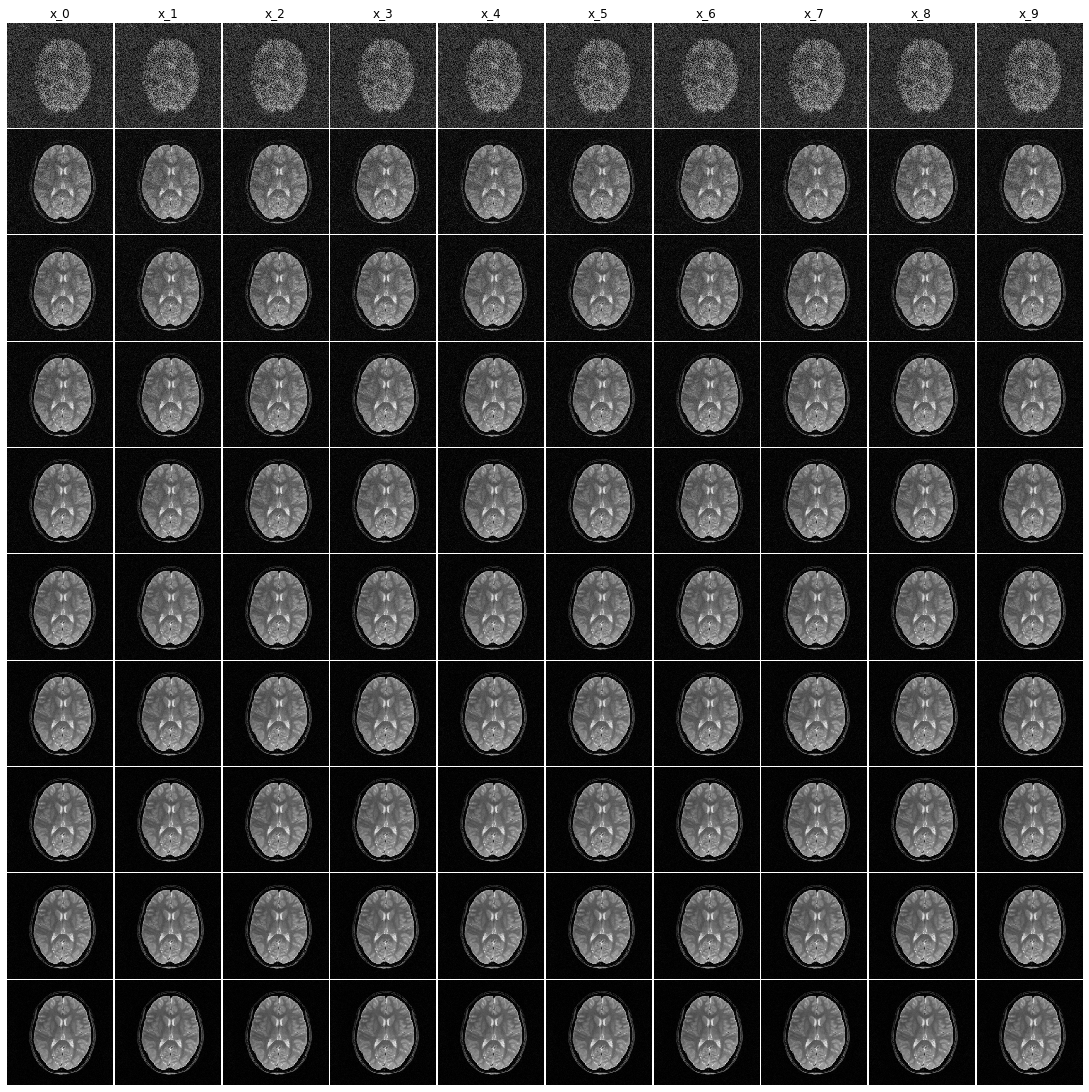

In [8]:
samples = normalized_rets[::35,...]

fig, axss = plt.subplots(10, 10, figsize=(15, 15), gridspec_kw={'width_ratios': [1 for _ in range(10)]})
for i in range(10):
    for j in range(10):
        if i==0:
            strs='x_%d'%j
        else:
            strs=''
        axplot(axss[i,j], samples[i,j], title=strs)
plt.tight_layout(pad=.1)